# kaggle 해커톤 . 6-2조
- 프로젝트 링크:
https://www.kaggle.com/c/competitive-data-science-predict-future-sales


## team
- 6-2조
- 이상국, 강명훈, 장선우

## 일정
### 1일차
- ~ : 각자 문제 및 데이터 파악
- 11:30 ~ : data 및 문제 관련 정의 (화상)
- ~ : 각자 진행
- 14:30 ~ : 진행 과정 토의1(화상) ex) 데이터 전처리, 모델정의
- ~ : 각자 진행   
- 17:00 ~ : 진행 과정 토의2(화상) , ex) 모델평가, 그리드서치, 앙상블, 모델개선 등..
- ~ 각자 진행   
<br/><br/>

### 2일차
- 10:00 ~ : 진행과정 토의3(화상),open meet
- ~ 각자 진행   
- 11:30 ~ : 제출 전 정리 미팅, 최고 스코어 도출
- ~ 각자 진행 또는 협업
- 14:00 ~ : 최종 제출

## 대회
- 2020.08.27(목)~2020.08.28(금) PM 2:00까지
- 캐글 Public Score 중 최고점을 슬랙 대회 채널에 jupyter notebook 파일과 함께 제출
- 제출 파일은 jupyter notebook이고,
- 형식은 Exploration 노드 과제 제출 형식과 동일합니다. (결과 출력, 로그 및 주요사항 reporting)

## 문제파악


### 디스크립션
- 러시아 최대 소프트웨어 회사 중 하나 인 1C Company 에서 친절하게 제공 한 일일 판매 데이터로 구성된 까다로운 시계열 데이터 세트


### file
- sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
- test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
- sample_submission.csv - a sample submission file in the correct format.
- items.csv - supplemental information about the items/products.
- item_categories.csv  - supplemental information about the items categories.
- shops.csv- supplemental information about the shops.

### filed 

- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- date_block_num==> 월 index data
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category

### 문제 정의
- 다음 달의 모든 제품 및 매장에 대한 총 매출을 예측

# library import

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error



#model 
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# hyper pram tuning library
from sklearn.model_selection import GridSearchCV

#time
import time

# data import

In [76]:
# data path set

data_dir = "./data"
train_data_path = join(data_dir, 'sales_train.csv') #train data
test_data_path = join(data_dir, 'test.csv') #test data

submission_path = join(data_dir, 'sample_submission.csv') #제출파일

categories_data_path = join(data_dir, 'item_categories.csv') #카테고리: 네임, 카테고리 아이디
items_path = join(data_dir, 'items.csv') # 아이템: 이름, id,  카테고리id
shops_path = join(data_dir, 'shops.csv') # 매장명: 매장명, id



# data import
origin_train = pd.read_csv(train_data_path)
origin_test = pd.read_csv(test_data_path)

submission_file = pd.read_csv(submission_path) #제출파일

# 
categories= pd.read_csv(categories_data_path)
items = pd.read_csv(items_path)
shops = pd.read_csv(shops_path)



# data 파악

In [77]:
origin_train.shape

(2935849, 6)

In [78]:
origin_train.dtypes # column data type 조회

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

In [79]:
origin_train.head()
# 월 정보 index column

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [80]:
origin_test.head() # test data

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [81]:
categories.head() # 카테고리 파일

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [82]:
shops.head() # 매장 파일

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [83]:
items.head() # 아이템 제품 파일

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [84]:
## 매장별 월별 데이터

# data preprocessing

In [85]:
##
origin_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [86]:
train = origin_train.copy()
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


## 결측 데이터 숙청

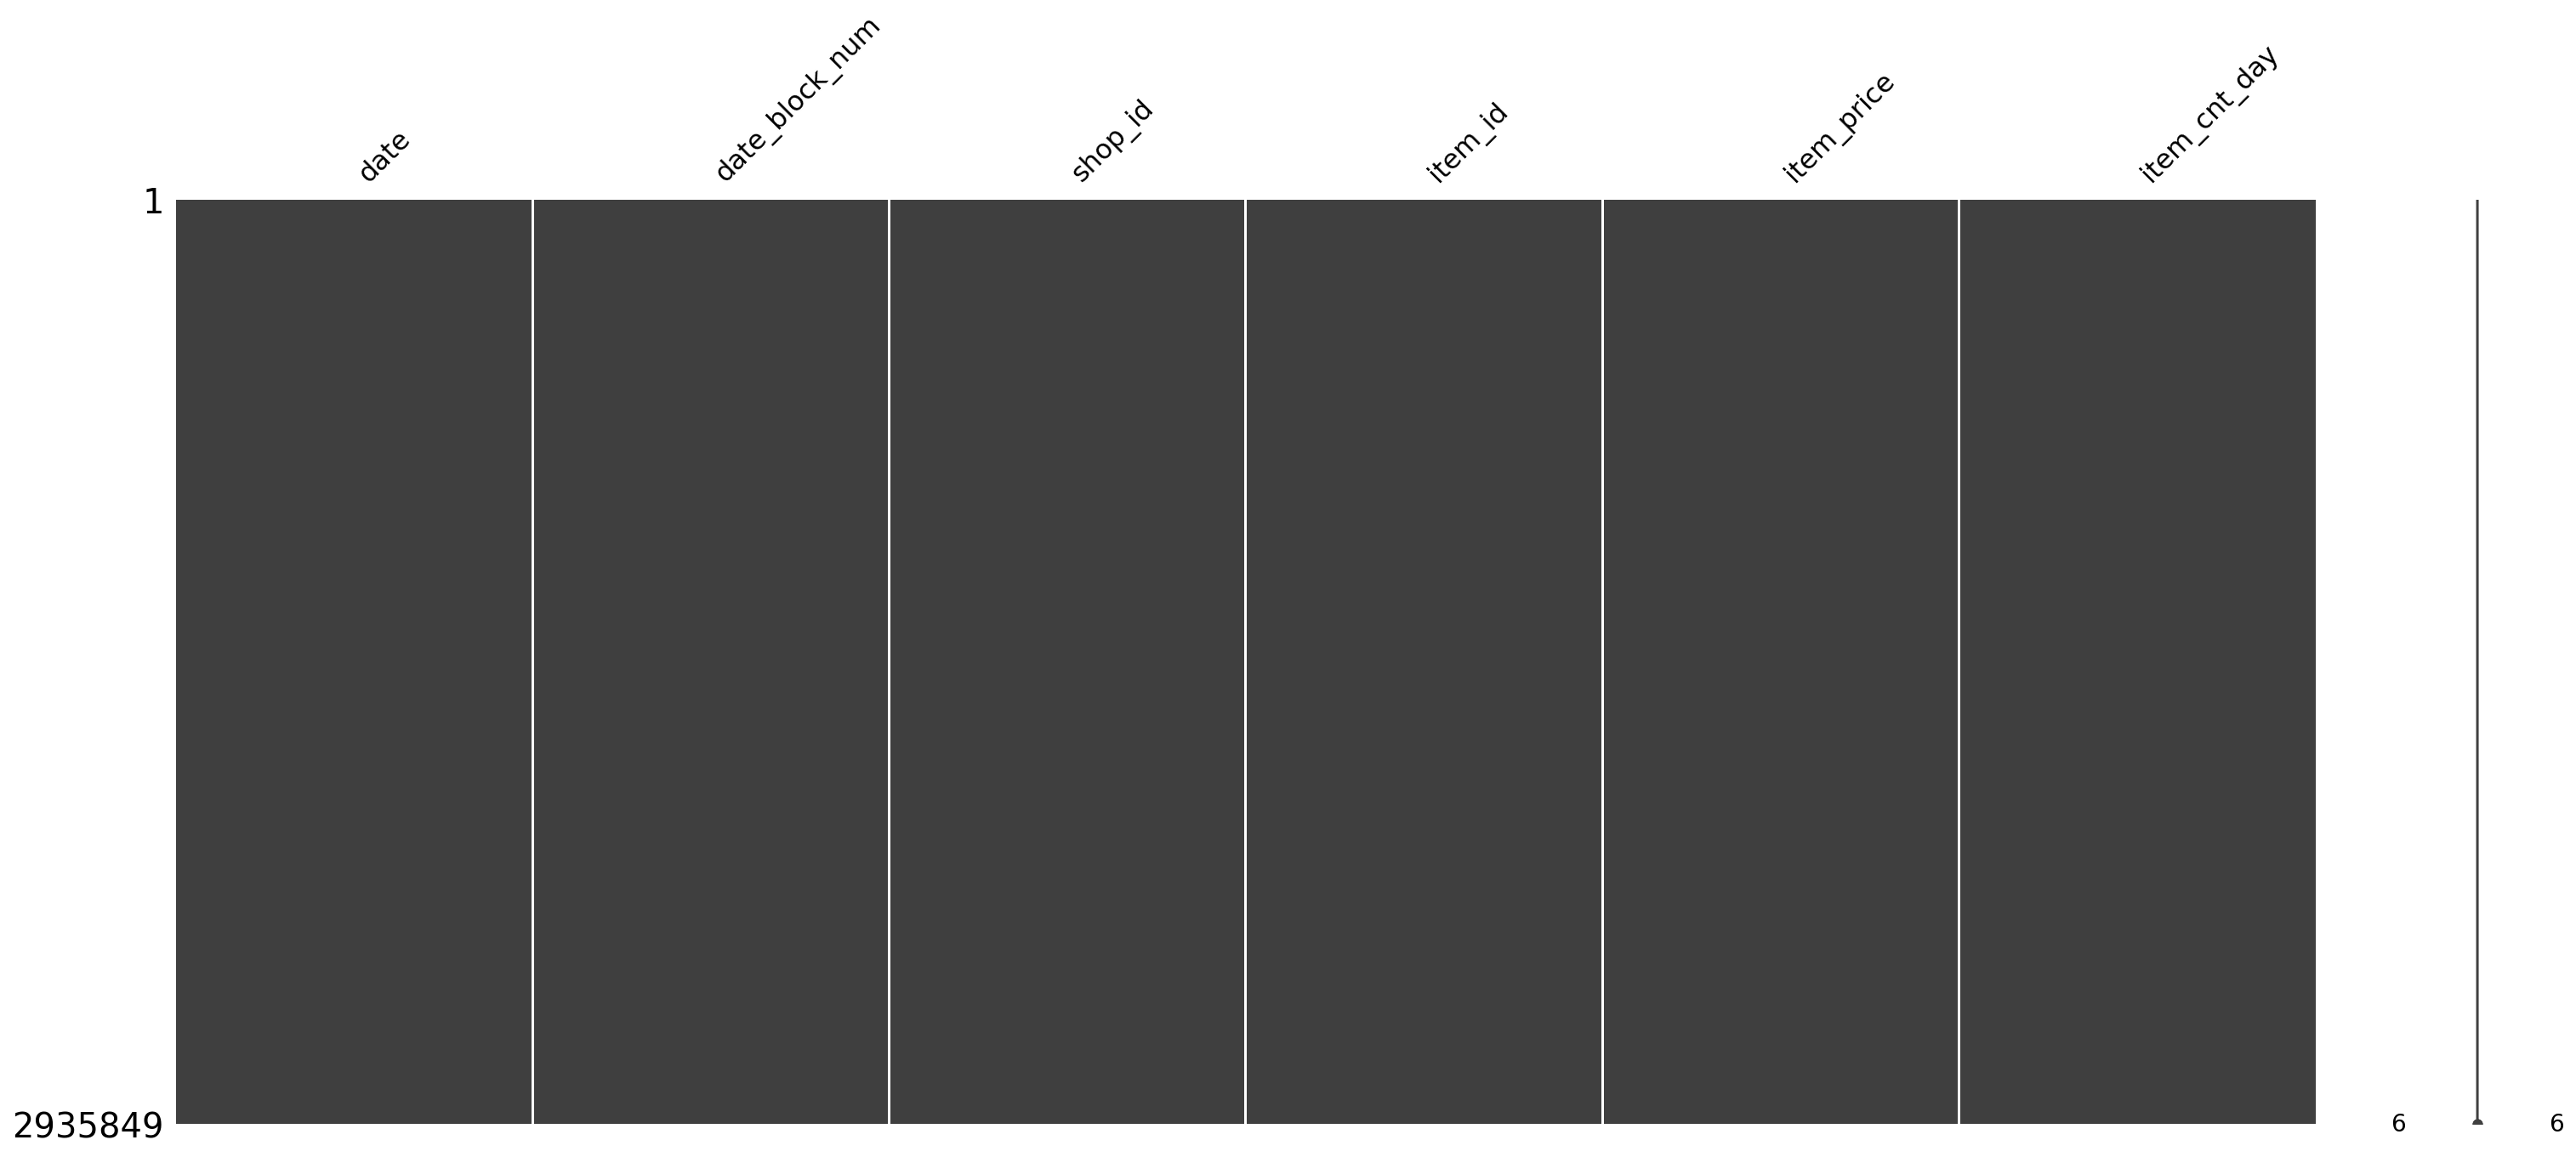

In [87]:
# 결측데이터 graph
msno.matrix(train)

In [88]:
print("------train data 결측------")
for c in train.columns:
    print('{} : {}'.format(c, len(train.loc[pd.isnull(train[c]), c].values)))
print("\n------test data 결측-------")
for c in train.columns:
    print('{} : {}'.format(c, len(train.loc[pd.isnull(train[c]), c].values)))

------train data 결측------
date : 0
date_block_num : 0
shop_id : 0
item_id : 0
item_price : 0
item_cnt_day : 0

------test data 결측-------
date : 0
date_block_num : 0
shop_id : 0
item_id : 0
item_price : 0
item_cnt_day : 0


In [89]:
#결측 데이더 없~~넹...

## 중복 데이터 숙청

In [90]:
train[train.duplicated()]
#6개 중복 데이터

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76962,05.01.2013,0,54,20130,149.0,1.0
1435367,23.02.2014,13,50,3423,999.0,1.0
1496766,23.03.2014,14,21,3423,999.0,1.0
1671873,01.05.2014,16,50,3423,999.0,1.0
1866340,12.07.2014,18,25,3423,999.0,1.0
2198566,31.12.2014,23,42,21619,499.0,1.0


In [91]:

def find_by_date_shopid_itemid(date, sid, iid):
    return train[(train['date'] == date)&(train['shop_id']==sid)&(train['item_id']==iid)]

d0 = find_by_date_shopid_itemid('05.01.2013', 54, 20130)
d1 = find_by_date_shopid_itemid('23.02.2014', 50, 3423)
d2 = find_by_date_shopid_itemid('23.03.2014', 21, 3423)
d3 = find_by_date_shopid_itemid('01.05.2014', 50, 3423)
d4 = find_by_date_shopid_itemid('12.07.2014', 25, 3423)
d5 = find_by_date_shopid_itemid('31.12.2014', 42, 21619)
print (d0)
print (d1)
print (d2)
print (d3)
print (d4)

             date  date_block_num  shop_id  item_id  item_price  item_cnt_day
76961  05.01.2013               0       54    20130       149.0           1.0
76962  05.01.2013               0       54    20130       149.0           1.0
               date  date_block_num  shop_id  item_id  item_price  \
1435365  23.02.2014              13       50     3423       999.0   
1435367  23.02.2014              13       50     3423       999.0   

         item_cnt_day  
1435365           1.0  
1435367           1.0  
               date  date_block_num  shop_id  item_id  item_price  \
1496765  23.03.2014              14       21     3423       999.0   
1496766  23.03.2014              14       21     3423       999.0   

         item_cnt_day  
1496765           1.0  
1496766           1.0  
               date  date_block_num  shop_id  item_id  item_price  \
1671872  01.05.2014              16       50     3423       999.0   
1671873  01.05.2014              16       50     3423       999.0   

In [92]:
#중복 데이터 숙청.
train.drop_duplicates(inplace=True)
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


## 이상치

### cnt_day , price

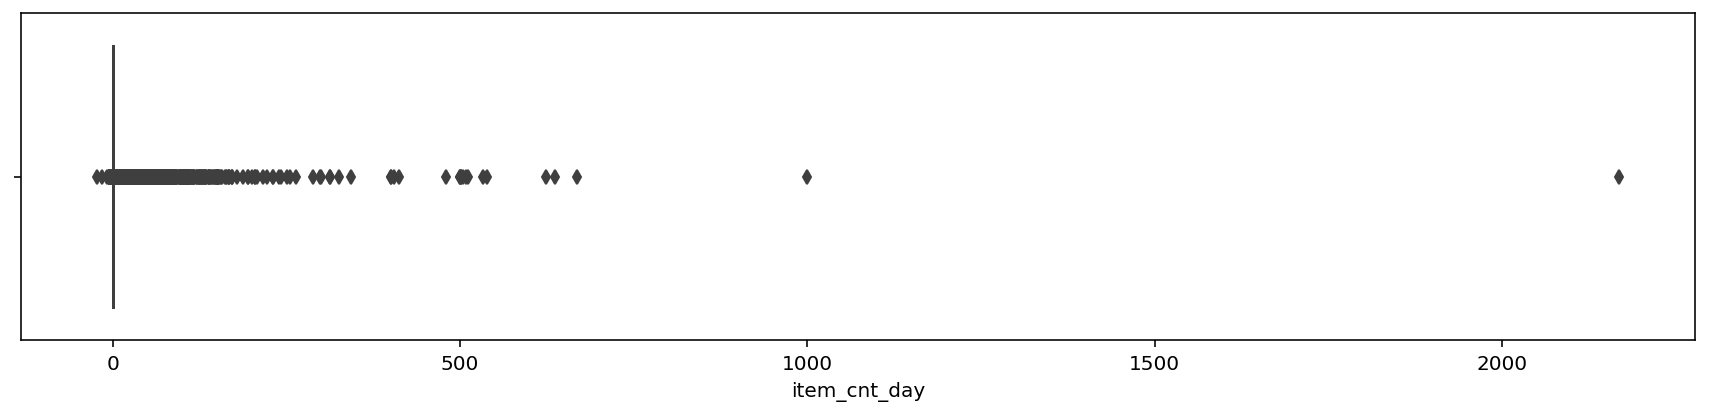

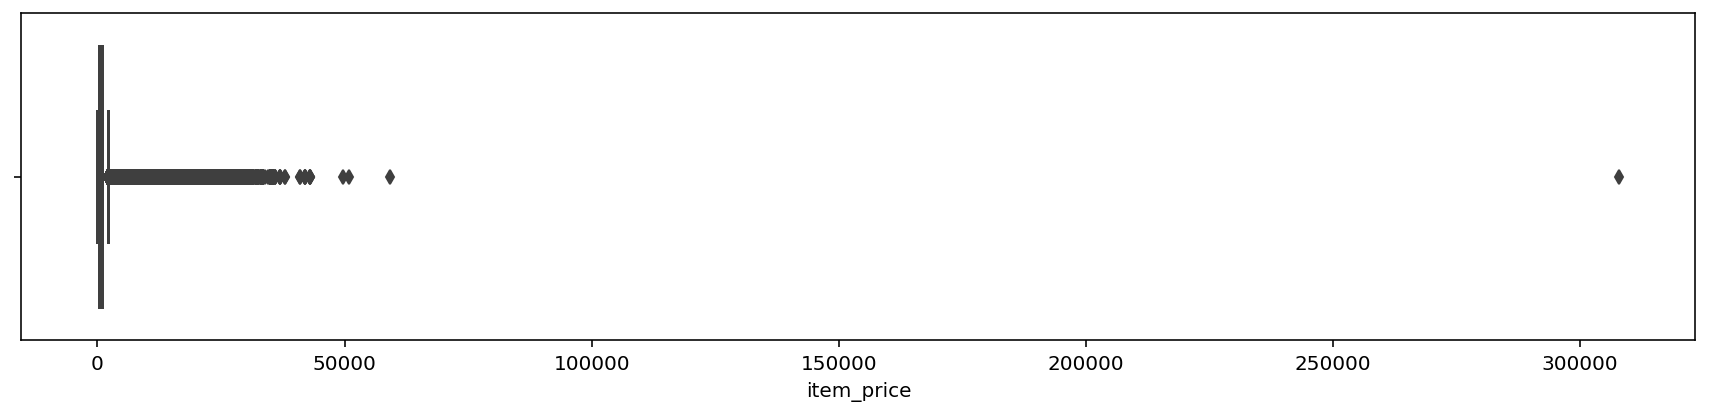

In [93]:
# 개수와 가격

plt.figure(figsize=(15,3))
sns.boxplot(x='item_cnt_day', data=train)

plt.figure(figsize=(15,3))
sns.boxplot(x='item_price', data=train);


In [94]:
#
train = train[train.item_cnt_day < 600]
train = train[train.item_price < 50000]
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


### data  (..)
 - 한 번에 요약된 통계 결과를 반환, 시리즈 혹은 데이터프레임의 각 열에 대한 요약 통계 

In [95]:
# data standardization
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935835e+06,2.935835e+06,2.935835e+06,2.935835e+06,2.935835e+06
mean,1.456989e+01,3.300175e+01,1.019723e+04,8.907117e+02,1.240907e+00
std,9.422982e+00,1.622696e+01,6.324296e+03,1.719908e+03,2.120441e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,4.978200e+04,5.390000e+02


In [96]:
train = train[train.item_cnt_day >= 0]
train = train[train.item_price >= 0]

### cnt_day 마이너스 데이터 처리(미적용)

- item_cnt_day < 0

In [97]:
train[train["item_cnt_day"] <0] # -data 조회

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


In [98]:
# -데이터 처리 여부 ............ 결제 취소인가.... 위에 처리.


### 오류데이터 수정

In [99]:
## kang
def set_value(data,str_item,condition,val):
    data.loc[condition, str_item] = val
#일부 shop_id  shop_name 하고 맞지않는 데이터가 있었다.

# 주콥스키 거리 Чкалова 39м²
set_value(train,'shop_id',train.shop_id == 10,11)
#set_value(test,'shop_id',test.shop_id == 10,11)

# 야쿠스크 Орджоникидзе, 56
set_value(train,'shop_id',train.shop_id == 0,57)
#set_value(test,'shop_id',test.shop_id == 0,57)

# 야쿠스크 ТЦ "Central"
set_value(train,'shop_id',train.shop_id == 1,58)
#set_value(test,'shop_id',test.shop_id == 1,58)




### 매장정보에 도시 데이터 추가

In [100]:
#Shops를 보면, shop_name의 첫 번째 단어가, 해당 상점이 해당하는 도시 이름입니다.
#예를 들어, 상점 이름이 "마포구 스타벅스" 식으로 되어있는 것이죠.
#따라서, shop_name 으로 부터, 도시 이름을 뽑아내고, 이를 새로운 Feature 로 둘 수 있습니다.
#이를 city 라고 하고, 이를 Label encoding 한 것을 city_code 라고 하겠습니다.

# 일부 데이터의 shop_name 이 통일되지 않는 것 수정.
set_value(shops,'shop_name',shops.shop_name == 'Сергиев Посад ТЦ "7Я"','СергиевПосад ТЦ "7Я"')

#shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
# shop_name 으로부터 city 를 추출하여 새로운 Feature를 만듭니다.
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])

set_value(shops,'city',shops.city == '!Якутск','Якутск') # 야쿠스크 역시, 통일되지 않은 도시라 보정.

#shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
#shops = shops[['shop_id','city_code']]
shops.head()

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский


In [101]:
## 도시 데이터 수치 데이터로 인코딩

In [102]:
shops.city.value_counts()

Москва              13
Якутск               4
Тюмень               3
РостовНаДону         3
Воронеж              3
Красноярск           2
Самара               2
Новосибирск          2
Н.Новгород           2
Жуковский            2
СПб                  2
Уфа                  2
Казань               2
Ярославль            1
Цифровой             1
Выездная             1
Сургут               1
Курск                1
Калуга               1
Интернет-магазин     1
Омск                 1
Мытищи               1
Томск                1
Коломна              1
Волжский             1
Балашиха             1
Адыгея               1
Вологда              1
Чехов                1
Химки                1
СергиевПосад         1
Name: city, dtype: int64

In [103]:
#인코딩
from sklearn.preprocessing import LabelEncoder
city_encoder = LabelEncoder()
shops['city_code'] = city_encoder.fit_transform(shops['city'])
shops = shops[['shop_id', 'city_code']]
shops.head()

,shop_id,city_code
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


## 매출 데이터 생성(일 별)
- 가격 * 아이템 수

In [104]:
train['sales_day'] = train['item_price'] * train['item_cnt_day']
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,sales_day
0,02.01.2013,0,59,22154,999.00,1.0,999.00
1,03.01.2013,0,25,2552,899.00,1.0,899.00
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00
5,10.01.2013,0,25,2564,349.00,1.0,349.00
...,...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0,299.00
2935845,09.10.2015,33,25,7460,299.00,1.0,299.00
2935846,14.10.2015,33,25,7459,349.00,1.0,349.00
2935847,22.10.2015,33,25,7440,299.00,1.0,299.00


## 불필요 데이터 숙청
- date 의 날짜 제외

In [105]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,sales_day
0,02.01.2013,0,59,22154,999.00,1.0,999.00
1,03.01.2013,0,25,2552,899.00,1.0,899.00
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00
5,10.01.2013,0,25,2564,349.00,1.0,349.00


In [106]:
D_train = train.drop(['date','item_price','item_cnt_day'], axis=1, inplace=False)
D_train

,date_block_num,shop_id,item_id,sales_day
0,0,59,22154,999.00
1,0,25,2552,899.00
3,0,25,2554,1709.05
4,0,25,2555,1099.00
5,0,25,2564,349.00
...,...,...,...,...
2935844,33,25,7409,299.00
2935845,33,25,7460,299.00
2935846,33,25,7459,349.00
2935847,33,25,7440,299.00


## 월별 데이터로 그룹
- 매장별 아이템합 , 월별 그룹핑

In [107]:
# 그룹핑
G_train = D_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg('sum')

G_train.reset_index(inplace=True) # indexing
G_train = G_train.rename({'sales_day':'sales_month'}, axis='columns') # column 명 변경
G_train.columns

Index(['date_block_num', 'shop_id', 'item_id', 'sales_month'], dtype='object')

In [108]:
G_train.dtypes
G_train

,date_block_num,shop_id,item_id,sales_month
0,0,2,27,2499.0
1,0,2,33,499.0
2,0,2,317,299.0
3,0,2,438,299.0
4,0,2,471,798.0
...,...,...,...,...
1608218,33,59,22087,714.0
1608219,33,59,22088,238.0
1608220,33,59,22091,179.0
1608221,33,59,22100,629.0


In [109]:
#카테고리 ID 붙여보기


In [110]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


## 컬럼 카테고리 아이디, 도시 아이디 붙이기

In [111]:
## 카테고리 아이디 붙이기
c_train = pd.merge(left=G_train, right=items[['item_category_id','item_id']], how="left", on='item_id', sort=False)
c_train

,date_block_num,shop_id,item_id,sales_month,item_category_id
0,0,2,27,2499.0,19
1,0,2,33,499.0,37
2,0,2,317,299.0,45
3,0,2,438,299.0,45
4,0,2,471,798.0,49
...,...,...,...,...,...
1608218,33,59,22087,714.0,83
1608219,33,59,22088,238.0,83
1608220,33,59,22091,179.0,83
1608221,33,59,22100,629.0,42


In [112]:
## 도시 아이디 붙이기
c_train = pd.merge(left=c_train, right=shops[['city_code','shop_id']], how="left", on='shop_id', sort=False)
c_train

,date_block_num,shop_id,item_id,sales_month,item_category_id,city_code
0,0,2,27,2499.0,19,0
1,0,2,33,499.0,37,0
2,0,2,317,299.0,45,0
3,0,2,438,299.0,45,0
4,0,2,471,798.0,49,0
...,...,...,...,...,...,...
1608218,33,59,22087,714.0,83,30
1608219,33,59,22088,238.0,83,30
1608220,33,59,22091,179.0,83,30
1608221,33,59,22100,629.0,42,30


In [113]:
# SHOP ID / ITEM ID 개수 / 카테고리 개수
len(c_train['shop_id'].value_counts()), len(c_train['item_id'].value_counts()),len(c_train['item_category_id'].value_counts())

(57, 21802, 84)

## y, sales_month 값 분포조정

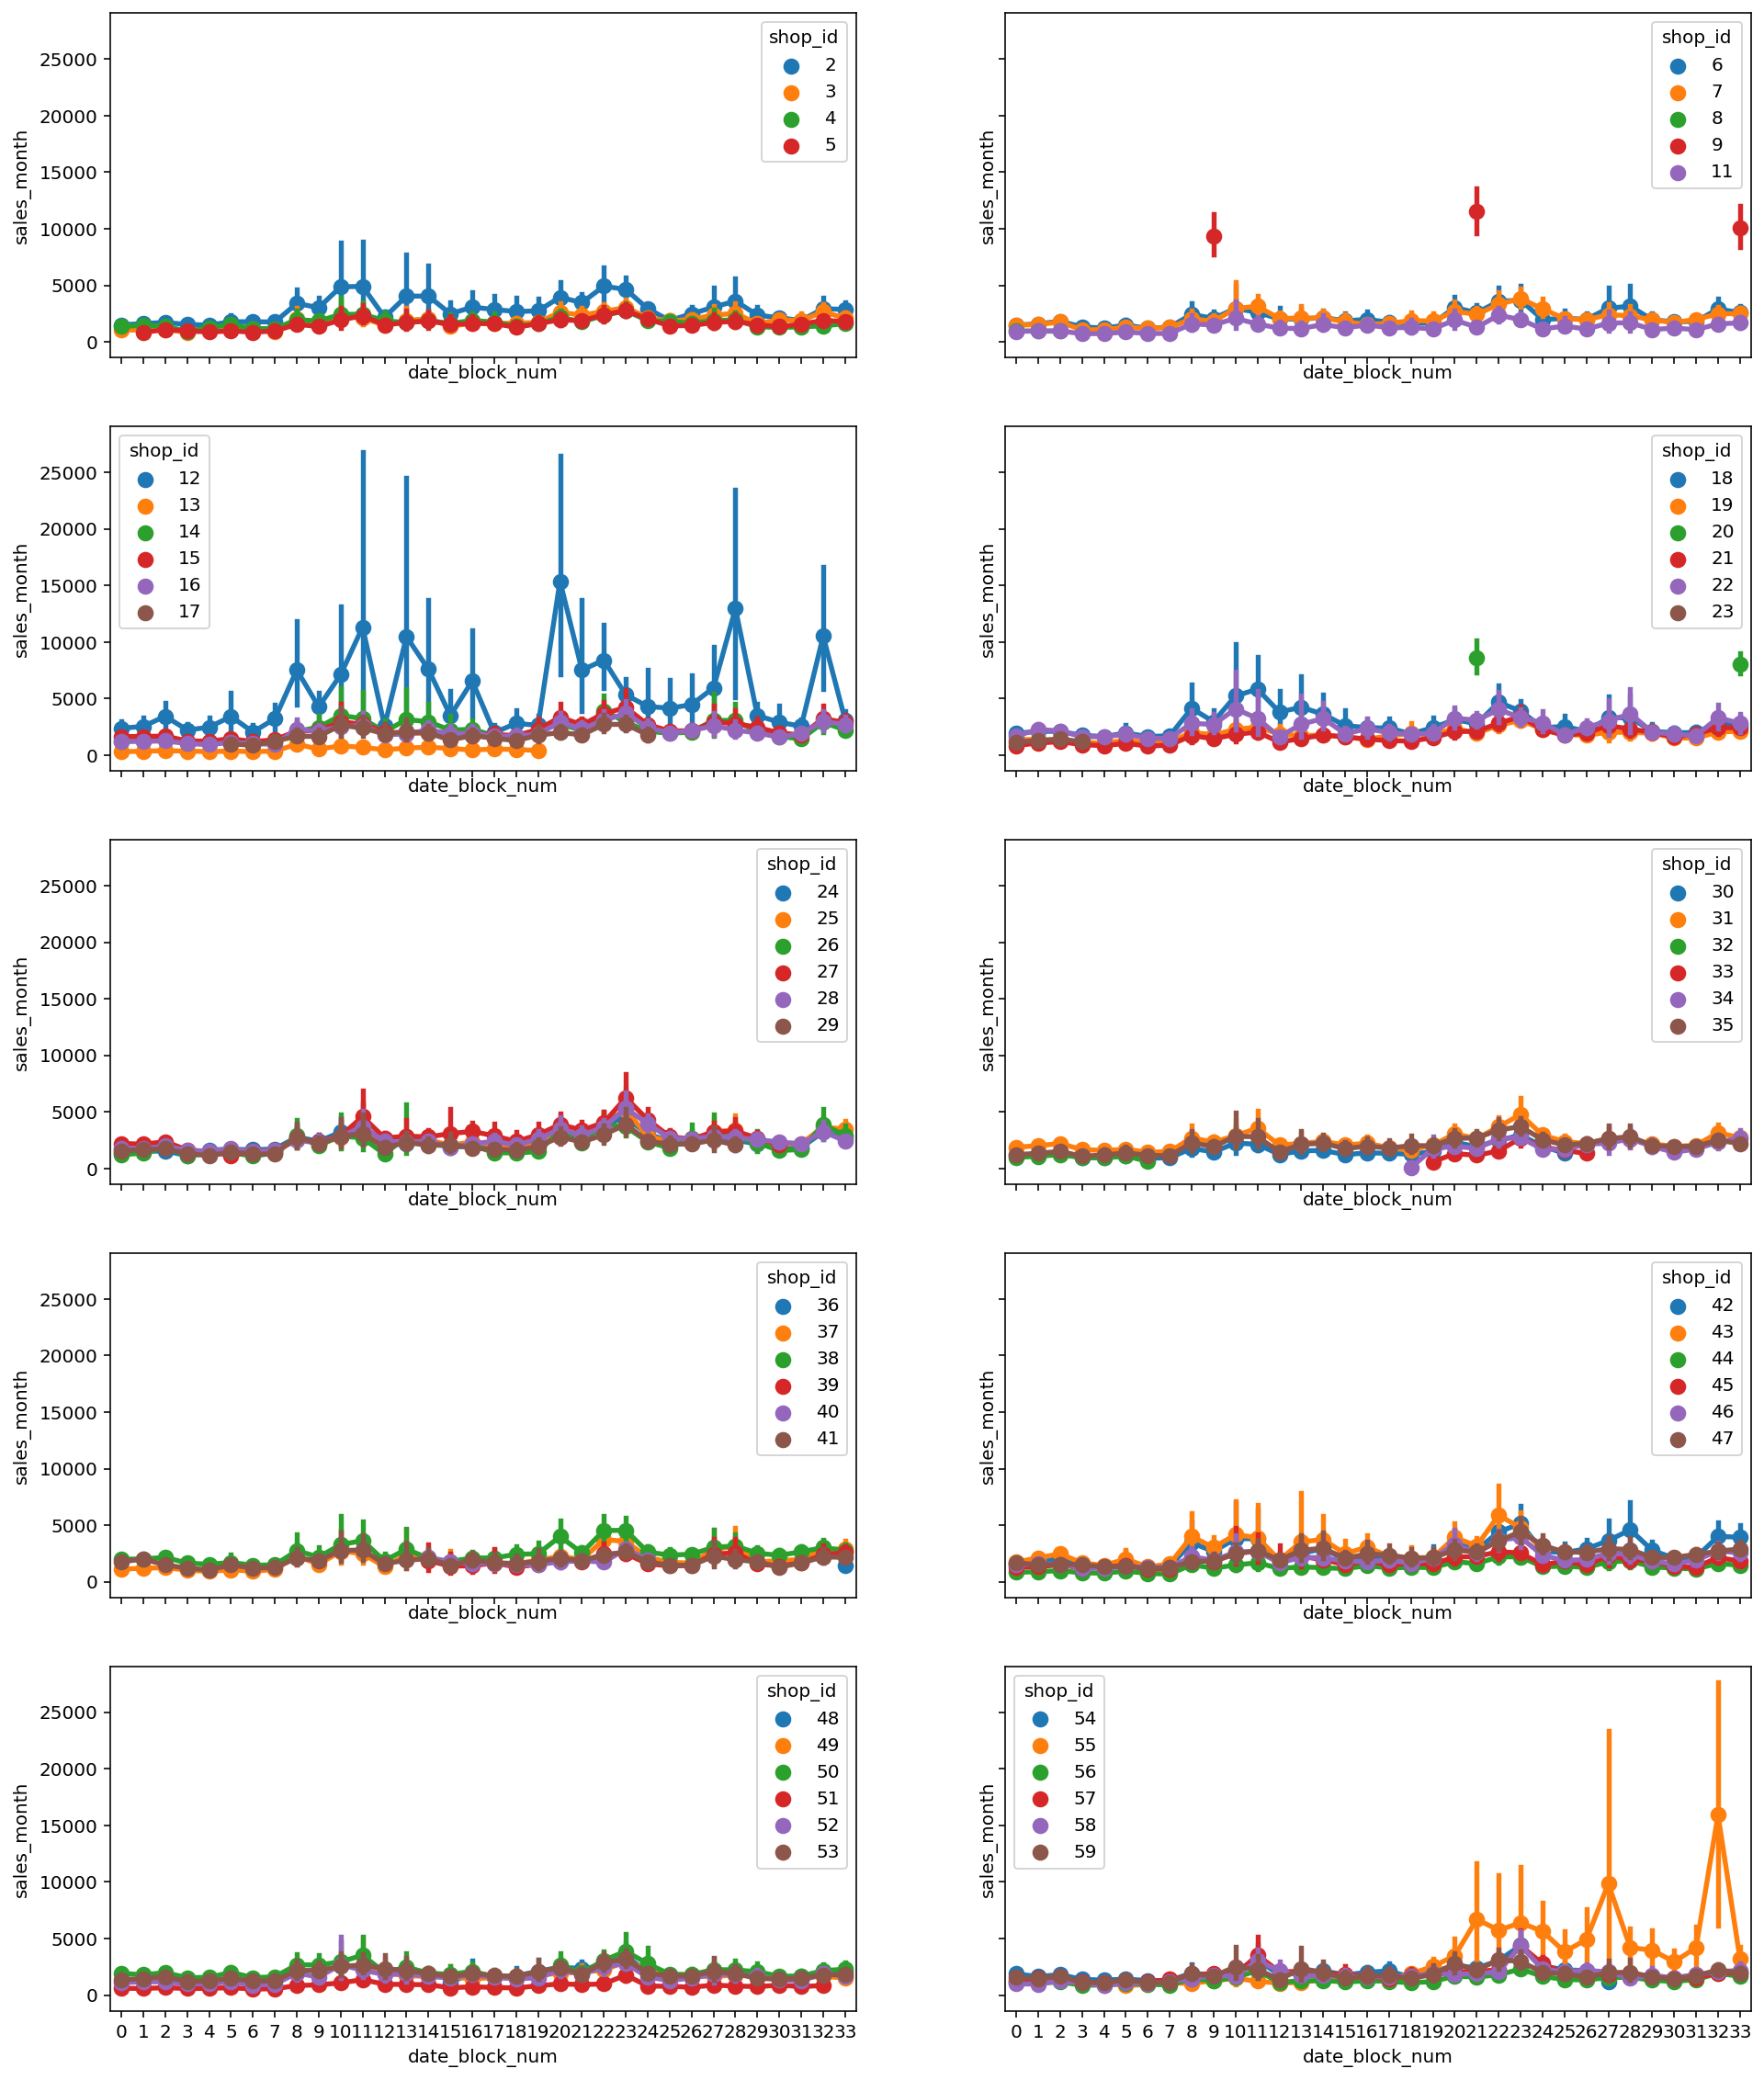

In [75]:
import math
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = math.ceil(G_train.shop_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='sales_month', hue='shop_id', data=G_train[np.logical_and(count*id_per_graph <= G_train['shop_id'], G_train['shop_id'] < (count+1)*id_per_graph)], ax=axes[i][j])
        count += 1

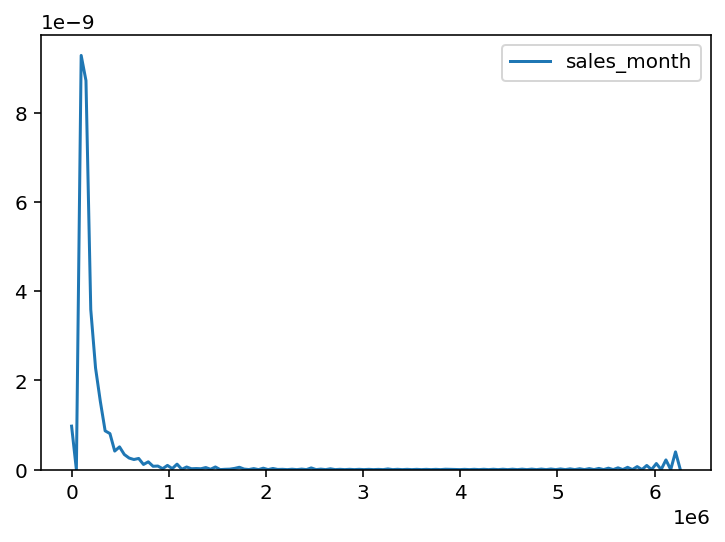

In [40]:
sns.kdeplot(c_train['sales_month'])
plt.show()

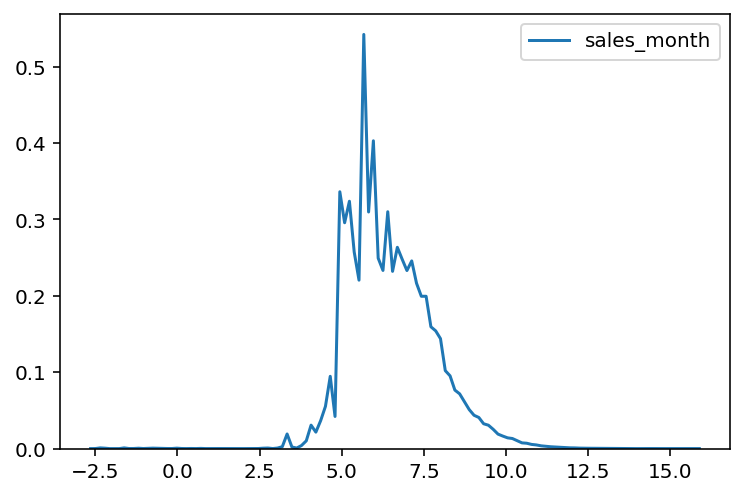

In [41]:

# price 값의 분포 
c_train['sales_month']= np.log(c_train['sales_month']) # log 먹어랑.
sns.kdeplot(c_train['sales_month'])
plt.show()

# test 값..... 처리

In [42]:
test_data = origin_test.copy()
test_data

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [43]:
test_data.drop("ID", axis="columns", inplace=True)
test_data

,shop_id,item_id
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268
...,...,...
214195,45,18454
214196,45,16188
214197,45,15757
214198,45,19648


## date_block_num column 추가

In [44]:
# blokcnum 33 다음인.
test_data['date_block_num'] = 34
test_data

,shop_id,item_id,date_block_num
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34
...,...,...,...
214195,45,18454,34
214196,45,16188,34
214197,45,15757,34
214198,45,19648,34


## category id 추가

In [45]:
c_test_data = pd.merge(left=test_data, right=items[['item_category_id','item_id']], how="left", on='item_id', sort=False)
c_test_data

,shop_id,item_id,date_block_num,item_category_id
0,5,5037,34,19
1,5,5320,34,55
2,5,5233,34,19
3,5,5232,34,23
4,5,5268,34,20
...,...,...,...,...
214195,45,18454,34,55
214196,45,16188,34,64
214197,45,15757,34,55
214198,45,19648,34,40


### city _code 추가

In [46]:

c_test_data = pd.merge(left=c_test_data, right=shops[['city_code','shop_id']], how="left", on='shop_id', sort=False)
c_test_data


,shop_id,item_id,date_block_num,item_category_id,city_code
0,5,5037,34,19,3
1,5,5320,34,55,3
2,5,5233,34,19,3
3,5,5232,34,23,3
4,5,5268,34,20,3
...,...,...,...,...,...
214195,45,18454,34,55,20
214196,45,16188,34,64,20
214197,45,15757,34,55,20
214198,45,19648,34,40,20


# x train / x_valid(검증) / x_test 데이터 split


In [47]:
data_x = c_train[c_test_data.columns]
data_y = c_train[['sales_month','date_block_num']]
data_x

,shop_id,item_id,date_block_num,item_category_id,city_code
0,2,27,0,19,0
1,2,33,0,37,0
2,2,317,0,45,0
3,2,438,0,45,0
4,2,471,0,49,0
...,...,...,...,...,...
1608218,59,22087,33,83,30
1608219,59,22088,33,83,30
1608220,59,22091,33,83,30
1608221,59,22100,33,42,30


In [48]:
X_train = data_x[data_x.date_block_num < 33]
Y_train = data_y[data_y.date_block_num < 33]['sales_month']
X_valid = data_x[data_x.date_block_num >= 33]
Y_valid = data_y[data_y.date_block_num >= 33]['sales_month']

X_test = c_test_data

In [49]:
X_train

,shop_id,item_id,date_block_num,item_category_id,city_code
0,2,27,0,19,0
1,2,33,0,37,0
2,2,317,0,45,0
3,2,438,0,45,0
4,2,471,0,49,0
...,...,...,...,...,...
1576697,59,22087,32,83,30
1576698,59,22088,32,83,30
1576699,59,22091,32,83,30
1576700,59,22100,32,42,30


# model 

## model define

### 단일 모델

In [50]:
# 단일모델 xgbr 3092

model1 = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model1.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

[0]	validation_0-rmse:4.32135	validation_1-rmse:4.55709
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:3.09051	validation_1-rmse:3.28533
[2]	validation_0-rmse:2.25478	validation_1-rmse:2.41963
[3]	validation_0-rmse:1.70027	validation_1-rmse:1.83070
[4]	validation_0-rmse:1.34013	validation_1-rmse:1.44088
[5]	validation_0-rmse:1.12165	validation_1-rmse:1.20088
[6]	validation_0-rmse:0.99045	validation_1-rmse:1.05096
[7]	validation_0-rmse:0.92012	validation_1-rmse:0.95913
[8]	validation_0-rmse:0.87823	validation_1-rmse:0.91187
[9]	validation_0-rmse:0.85318	validation_1-rmse:0.88113
[10]	validation_0-rmse:0.84066	validation_1-rmse:0.85971
[11]	validation_0-rmse:0.83383	validation_1-rmse:0.84917
[12]	validation_0-rmse:0.82987	validation_1-rmse:0.84254
[13]	validation_0-rmse:0.82591	validation_1-rmse:0.83474
[14]	validation_0-rmse:0.82074	validation_1-rmse:0.83

[141]	validation_0-rmse:0.68315	validation_1-rmse:0.73881
[142]	validation_0-rmse:0.68270	validation_1-rmse:0.73882
[143]	validation_0-rmse:0.68235	validation_1-rmse:0.73881
[144]	validation_0-rmse:0.68202	validation_1-rmse:0.73843
[145]	validation_0-rmse:0.68146	validation_1-rmse:0.73827
[146]	validation_0-rmse:0.68066	validation_1-rmse:0.73798
[147]	validation_0-rmse:0.68051	validation_1-rmse:0.73803
[148]	validation_0-rmse:0.68043	validation_1-rmse:0.73800
[149]	validation_0-rmse:0.68032	validation_1-rmse:0.73787
[150]	validation_0-rmse:0.67994	validation_1-rmse:0.73778
[151]	validation_0-rmse:0.67975	validation_1-rmse:0.73762
[152]	validation_0-rmse:0.67962	validation_1-rmse:0.73761
[153]	validation_0-rmse:0.67954	validation_1-rmse:0.73760
[154]	validation_0-rmse:0.67947	validation_1-rmse:0.73748
[155]	validation_0-rmse:0.67940	validation_1-rmse:0.73747
[156]	validation_0-rmse:0.67934	validation_1-rmse:0.73747
[157]	validation_0-rmse:0.67916	validation_1-rmse:0.73756
[158]	validati

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=8,
             min_child_weight=300, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=0.8, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [ ]:
Y_pred1 = model1.predict(X_valid).clip(0, 20)
Y_pred1


In [52]:
Y_test1 = model1.predict(X_test).clip(0, 20)
Y_test1

array([7.7285714, 6.306754 , 7.0926757, ..., 5.628851 , 5.5215063,
       5.4746437], dtype=float32)

### 앙상블 & 그리드

In [58]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=1818        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)



#models = [gboost, xgboost, lightgbm, rdforest, grid_model]

modelList = [{'model':gboost, 'name':'GradientBoosting'}, 
          {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'},
          {'model':rdforest, 'name':'rdforest'},
          #{'model':grid_lightgbm_model, 'name':'grid_lightgbm_model'},
         # {'model':grid_xgboost_model, 'name':'grid_xgboost_model'},
         # {'model':grid_rdforest_model, 'name':'grid_rdforest_model'}
         
         ]

#### 모델 평가...

In [59]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019).get_n_splits(train.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], X_train, Y_train)), 
                                             kf=kfold))
    print('----------------------end-----------------------')

In [127]:
#get_cv_score(modelList) 
# 오래걸림 20분 이상.

![ㅇ](./imgs.scores.png)

#### 그리드 서치 활용 모델 개선 (미적용)

In [61]:
lightgbm_param_grid = {
    'n_estimators': [10, 100],
    'max_depth': [1, 100],
#     'n_estimators': [50, 100],
#     'max_depth': [1, 10],
}

xgb_param_grid = {
    'n_estimators': [10, 50],
    'max_depth': [1,10],
}

rd_param_grid = {
    'n_estimators': [10, 50],
    'max_depth': [1, 100],

}

In [62]:
# 그리드 서치 모델 정의
grid_lightgbm_model = GridSearchCV(lightgbm, param_grid=lightgbm_param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)
grid_xgboost_model = GridSearchCV(xgboost, param_grid=xgb_param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)
grid_rdforest_model = GridSearchCV(rdforest, param_grid=rd_param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

In [65]:
#그리드 서치  fit
grid_lightgbm_model.fit(X_train, Y_train)

grid_xgboost_model.fit(X_train, Y_train)

grid_rdforest_model.fit(X_train, Y_train)

In [ ]:
#결과 조회
grid_lightgbm_model.cv_results_
grid_xgboost_model.cv_results_
grid_rdforest_model.cv_results_

In [ ]:
# param <조회
lightgbm_params = grid_lightgbm_model.cv_results_['params']
xgboost_params = grid_xgboost_model.cv_results_['params']
rdforest_params = grid_rdforest_model.cv_results_['params']

#socre 조회
# 스코어 조회
grid_lightgbm_score = grid_lightgbm_model.cv_results_['mean_test_score']
grid_xgboost_score = grid_xgboost_model.cv_results_['mean_test_score']
grid_rdforest_score = grid_rdforest_model.cv_results_['mean_test_score']

# DataFrame
grid_lightgbm_df = pd.DataFrame(lightgbm_params)
grid_lightgbm_df["score"]= grid_lightgbm_score
grid_lightgbm_df['RMSE'] = np.sqrt(-1 * grid_lightgbm_df['score']) # 
grid_lightgbm_df = grid_lightgbm_df.rename(columns={'RMSE': 'RMSLE'}) #컬럼명 변경
grid_lightgbm_df.sort_values(by="RMSLE", ascending=True, inplace=True) #정렬

grid_xgboost_df = pd.DataFrame(xgboost_params)
grid_xgboost_df["score"]= grid_xgboost_score
grid_xgboost_df['RMSE'] = np.sqrt(-1 * grid_xgboost_df['score'])
grid_rdforest_df = grid_xgboost_df.rename(columns={'RMSE': 'RMSLE'})
grid_rdforest_df.sort_values(by="RMSLE", ascending=True, inplace=True)

grid_rdforest_df = pd.DataFrame(rdforest_params)
grid_rdforest_df["score"]= grid_rdforest_score
grid_rdforest_df['RMSE'] = np.sqrt(-1 * grid_rdforest_df['score']) 
grid_rdforest_df = grid_rdforest_df.rename(columns={'RMSE': 'RMSLE'})
grid_rdforest_df.sort_values(by="RMSLE", ascending=True, inplace=True)

print('\n---lightgbm_score--')
print (grid_lightgbm_df)

print('\n ---xgboost_score---')
print (grid_xgboost_df)

print('\n---rdforest_score---')
print (grid_rdforest_df)

#### 모델 재정의

In [128]:
# 그리드 서치를 토대로 파라미터 변경
grid_lightgbm_model = LGBMRegressor(max_depth=30, n_estimators=300, random_state=random_state)
grid_xgboost_model = XGBRegressor(max_depth=10, n_estimators=50, random_state=random_state)
grid_rdforest_model = RandomForestRegressor(max_depth=50, n_estimators=800, random_state=random_state)

gboost = GradientBoostingRegressor(random_state=random_state)

models = [
#    {'model':gboost, 'name':'GradientBoosting'}, 
          {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'},
          {'model':rdforest, 'name':'rdforest'}, 
#{'model':grid_lightgbm_model, 'name':'grid_lightgbm_model'},
{'model':grid_xgboost_model, 'name':'grid_xgboost_model'}
#{'model':grid_rdforest_model, 'name':'grid_rdforest_model'}
]

In [129]:
## 모델별 학습및 예측, rsme 값 도출
# rmse 함수 정의
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [116]:
df = {}

for M in models:
    
    #모델
    model = M['model']
    # 모델 이름 획득
    model_name = M['name']
    
    #print(model_name)
    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    # X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
    
    #이미 나눔.
    #  data_x,data_y, X_test = c_test_data
    #    X_train = data_x[data_x.date_block_num < 33]
    #     Y_train = data_y[data_y.date_block_num < 33]['sales_month']
    #     X_valid = data_x[data_x.date_block_num >= 33]
    #     Y_valid = data_y[data_y.date_block_num >= 33]['sales_month']
    #     X_test = c_test_data
    
    # 모델 학습
    model.fit(X_train, X_valid)
    
    # 예측
    y_pred = model.predict(X_valid)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(Y_valid, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

ValueError: DataFrame for label cannot have multiple columns

#### 앙상블

In [130]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [131]:
y_pred = AveragingBlending(models, X_train, Y_train, X_test)
print(len(y_pred))
y_pred

214200


array([7.40278502, 6.16577798, 7.3853573 , ..., 5.57853272, 5.51687825,
       5.63400054])

In [133]:
y_pred

array([7.40278502, 6.16577798, 7.3853573 , ..., 5.57853272, 5.51687825,
       5.63400054])

# 제출 데이터 생성

In [134]:

#예측값 price 원래 스케일로..

prediction= np.expm1(y_pred) # Y_test1
prediction

array([1639.5470303 ,  475.17145008, 1611.2037259 , ...,  263.68295791,
        247.85695308,  278.77914846])

In [135]:
submission_file.head()

,ID,item_cnt_month
0,0,1395.464023
1,1,573.471587
2,2,1724.946997
3,3,935.500983
4,4,1755.789236


In [136]:
# 결과 덮어쓰기
submission_file['item_cnt_month'] = prediction

In [137]:
submission_file.head()

,ID,item_cnt_month
0,0,1639.547030
1,1,475.171450
2,2,1611.203726
3,3,1059.290351
4,4,2012.720787


In [138]:
now = time.gmtime(time.time())
nowt= str(now.tm_mon) +'-' + str(now.tm_mday)   +',' + str(now.tm_hour)  +':' + str(now.tm_min)
submission_csv_path = '{}/submission_vol_{}.csv'.format('./result'  ,nowt)
submission_file.to_csv(submission_csv_path, index=False)

# reference

- https://github.com/BaekKyunShin/Kaggle/blob/master/Predict_Future_Sales/Predict%20Future%20Sales.ipynb

- https://www.kaggle.com/jagangupta/time-series-basics-exploring-traditional-ts

# comment

## 팀원 코멘트

- 장선우: 각각의 데이터를 어떻게 구성할지에 대한 이해가 부족했던 것 같습니다. 큰 흐름을 잡지 못하고 세세한 부분부터 전처리를 시작하다보니 방향을 잃었습니다.
전처리에 너무 많은 시간을 소요하여 모델 구성과 하이퍼파라미터 튜닝에 집중하지 못했던 점이 아쉽습니다.
그러나 함께 고민하고 최선을 다하는 모습이 의미있었습니다. 앞으로 프로젝트를 어떻게 진행해야 하는지에 대해 이해할 수 있는 기회였습니다.

- 강명훈: 

- 이상국: 

### 스코어....

![a]('./imgs/f-s.png')

### 총평






- 컬럼 (shop id /itemid / block num / item category id ) xgbregressor 훈련, 스코어 : 3092.83391 ㅠㅠ
- 최초에 컬럼에 도시코드 인코딩해서 추가(city code) xgbregressor훈련, 스코어 : 2922.29201 ㅠㅠ
- 모델 앙상블 추가.XGBoost rdforest 스코어 3503.06121 ㅠㅠ


- model을 선정하고, 파리미터를 고치는 것이전에 전처리가 매우 중요하다는 것을 깨달았
- 전처리를 하기위해서는 데이터를 수집한사람의 의도의 데이터들의 의미들을 명확히 파악해야 적용할 수 있는 것 같다.



